# Programming Machine Learning Lab
# Exercise 4

**General Instructions:**

1. You need to submit the PDF as well as the filled notebook file.
1. Name your submissions by prefixing your matriculation number to the filename. Example, if your MR is 12345 then rename the files as **"12345_Exercise_4.xxx"**
1. Complete all your tasks and then do a clean run before generating the final pdf. (_Clear All Ouputs_ and _Run All_ commands in Jupyter notebook)

**Exercise Specific instructions::**

1. You are allowed to use only NumPy and Pandas (unless stated otherwise). You can use any library for visualizations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Part 1

**Optimization Routines and Loss Functions**

In this part of the assignment we learn how to write modular programs and make our code reusable. For this, declare a class named $\textbf{Optimization}$ which has 2 inputs X and y as the class variables. Next, implement the following optimization algorithms in this class. 

- Stochastic Gradient Descent (For Mean Square Loss)
- Newton’s Method (For Cross Entropy Loss) 

You will need loss functions and their gradients for the optimization process. So implement a class $\textbf{Loss}$ which also takes in X and y and computes the following losses and their gradients.

- Mean Square Loss (for Regression)
- Cross Entropy Loss (for Classification)
    
Make the $\textbf{Loss}$ class such that you can access it from the $\textbf{Optimization}$ class.

*Note : You can use np.linalg.solve for solving linear equations*

In [2]:
#Helper Functions
class Functions:
    
    ## function for random sampling of data
    def random_sampler(self, perc=0.1):
        prop = int(len(self.X)*perc) #proportion of the data to be used for each iteration, here we have set it to 10% of the data
        ind = np.random.choice(range(len(self.X)), prop, replace=False)
        test_ind = list(set(range(len(self.X))) - set(ind)) #for using the rest sample as test set
        return self.X[ind],self.y[ind], self.X[test_ind], self.y[test_ind]
    
    ## funtion for normalizing the features
    def normalize_features(self,X,append=True):
        X = (X - np.mean(X, 0)) / np.std(X, 0) #normalize the features
        if append:
            X = np.append(np.ones(X.shape[0]).reshape(-1,1),X,1) #append column of ones for intercept
        return X
    
    ## for calculating the metrics
    def calculate_metrics(self, y, preds):
        
        ## accuracy is given by
        accuracy = 1-np.sum(np.abs(np.subtract(preds,y)))/len(preds)
        
        ## calculate the True Positives TP
        Tp = np.sum((y == True) & (preds == True))
        
        ## calculate the True Negatives TN
        Tn = np.sum((y == False) & (preds == False))
        
        ## calculate the False Positives FP
        Fp = np.sum((y == False) & (preds == True))
        
        ## calculate the False Negatives FN
        Fn = np.sum((y == True) & (preds == False))
        
        ## calculate the Precision P
        P = Tp/(Tp+Fp)
        
        ## calculate the Recall
        R = Tp/(Tp+Fn)
        
        ## calculate the F1 score
        F = 2/(1/P+1/R)
        
        ## making confusion matrix
        c = np.ones(4)
        c[0],c[1],c[2],c[3] = Tn, Fp, Fn, Tp
        c = c.reshape(2,2)
        
        return accuracy,P,R,F,c

In [3]:
### Write your code here
class Optimization(Functions):
    
    ## initializing class
    def __init__(self, X, y, loss):
        self.X = X
        self.y = y
        self.loss = loss
    
    ## stochastic gradient descent function
    def SGD(self, B, max_iter=1000,tolerance=1e-6,lr=0.001):
        #function for updating parameters using SGD
        loss_list = []
        test_loss_list=[]
        for it in range(max_iter):
            #sample a random x and y batch for training and validation
            x, y, x_test,y_test = self.random_sampler()
            
            #calculating the loss
            curr_loss, derv_loss, _ = self.loss(self, x, y, B)
            loss_list.append(curr_loss)
            
            curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            test_loss_list.append(curr_loss_test)
            
            #update the betas
            e = lr*derv_loss
            B = B - e
            
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                break
        return B,loss_list,test_loss_list
    
    ## Newton Method for Optimization
    def newton_optimization(self, B, max_iter=100, tolerance = 1e-4, lr=0.001):
        ## function for updating parameters using newton's method
        loss_list = []
        test_loss_list=[]
        x, y, x_test, y_test = self.random_sampler(perc = 0.80) # use 80-20 in the training too
        
        for it in range(max_iter):
            #calculate training loss
            curr_loss, gradient, hessian = self.loss(self, x, y, B)
            loss_list.append(curr_loss)
            
            #calculate test loss
            curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            test_loss_list.append(curr_loss_test)
            
            ## newton method
            e = -np.linalg.solve(hessian,gradient)
            B = B + lr*e
            
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                break
                
        return B,loss_list,test_loss_list
    
#Loss Class: It returns both the loss and the gradient
class Loss():
    ## mean square error loss which returns loss, first derivative and hessian
    def mean_square_loss(self, X, y, betas):
        N = len(X)
        pred = np.dot(X,betas)
        return (np.square(y-pred)).mean(), (-2.0 /N) * X.T.dot(y - X.dot(betas)), 1/N * np.matmul(X.T,X)
    
    ## cross entropy loss
    def cross_entropy_loss(self, X, y, B):
        N = len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        W = np.diag((p*(1-p)).reshape(-1))
        return (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))))[0][0], -np.dot(X.T,(y-p)), X.T@W@X

### Part 2

In this task, you are given a data set named **"regression.csv"**. 
- Split the dataset into 80% for training and 20% for test
- Check the correlation of features (X) with the target (Y) (Visually as well). 
- Remove the 3 least correlated variables. The correlation is checked only using the train dataset
- Perform standard scaling on the remaining feature Columns

Implement a class $\textbf{LinearRegression}$ that has at least two functions, $\textbf{fit}$ and $\textbf{predict}$ for fitting a linear regression model and predicting the results. You need to use the $\textbf{Optimization}$ and $\textbf{Loss}$ class inside this. Fit a linear regression model with *Mean Square Loss* and *Stochastic Gradient Descent*.

Also, generate the loss trajectory for both training and testing datasets


In [4]:
#Reading the data and splitting it into training and testing set
reg_data = pd.read_csv('regression.csv')
X,y = reg_data.iloc[:,:-1],reg_data.iloc[:,-1]
#let's split the data into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#to check correlation of the features with target in training data
train_df = pd.concat([X_train,y_train],axis=1)
plt.figure(figsize=(12, 8))
corr = train_df.corr()
#to remove least 3 correlated features
least_corr = corr.iloc[:,-1].abs().nsmallest(3).index
X_train = X_train.drop(least_corr, axis=1)
X_test = X_test.drop(least_corr, axis=1)
#normalizing data 
X_train_normalized = Functions().normalize_features(X_train.values)
X_test_normalized = Functions().normalize_features(X_test.values)

<Figure size 1200x800 with 0 Axes>

In [6]:
#### Write your code here
class LinearRegression():
    #initialization of class
    def __init__ (self, X, y):
        self.X = X
        self.y = y.reshape(-1,1)
    
    ## function for fitting the model    
    def fit(self, max_iter=100, tolerance=1e-6, lr=0.1):
        
        # generate a random Beta matrix for 1st iteration
        B = np.zeros((self.X.shape[1],1))

        #define optimizer
        optim = Optimization(self.X, self.y, Loss.mean_square_loss)
        B, loss, test_loss = optim.SGD(B, max_iter, tolerance, lr)
        self.B = B
        return B,loss,test_loss
        
    def predict(self,X):
        return np.matmul(X,self.B)

In [7]:
#Fit the model
lin_reg_model=LinearRegression(X_train_normalized,y_train.values)
lin_reg_model_params,train_loss,test_loss = lin_reg_model.fit()

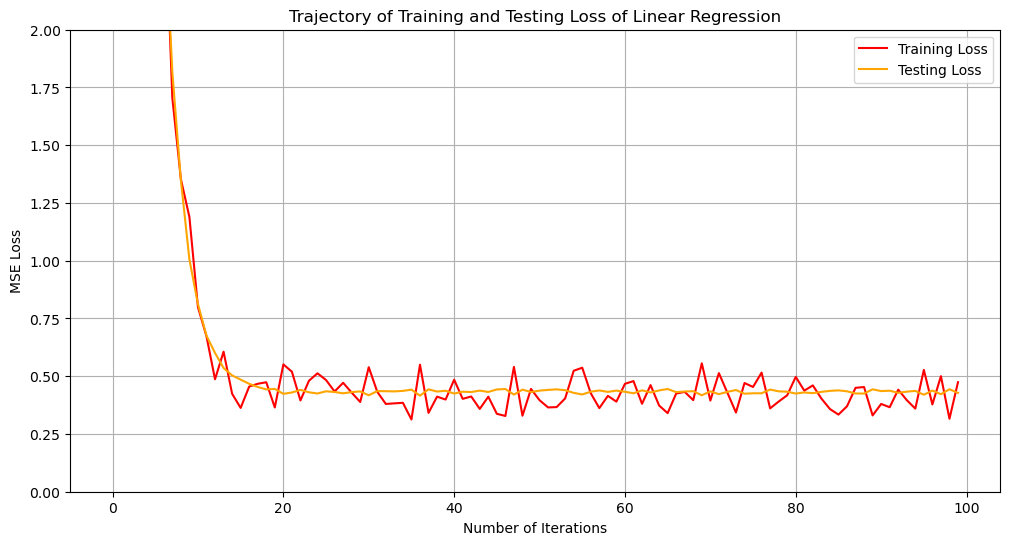

In [8]:
#Drawing the Trajectory of Loss
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.ylim([0,2]);
plt.title('Trajectory of Training and Testing Loss of Linear Regression');
plt.xlabel('Number of Iterations');
plt.ylabel('MSE Loss');
plt.legend();
plt.grid('on');

**Evaluation**

Compute the test predictions using the Linear Regression from sklearn and compare the Betas and Results to your implementation.

In [9]:
#### Write your code here
from sklearn.linear_model import LinearRegression
sklearn_reg = LinearRegression()
sklearn_reg.fit(X_train_normalized[:,1:],y_train)

LinearRegression()

In [10]:
lin_reg_preds = lin_reg_model.predict(X_test_normalized)
sklearn_preds = sklearn_reg.predict(X_test_normalized[:,1:])
#sklearn returns coef and intercept differently let's append them
sklearn_reg_params = np.append(sklearn_reg.intercept_,sklearn_reg.coef_)
lin_reg_loss, _, _ = Loss().mean_square_loss(X_train_normalized, y_train.values, lin_reg_model_params)
sklearn_reg_loss, _, _ = Loss().mean_square_loss(X_train_normalized, y_train.values, sklearn_reg_params)
print('The loss of our implementation is:',lin_reg_loss)
print('The loss of Sklearn Implementation is',sklearn_reg_loss)

The loss of our implementation is: 0.9171665064431149
The loss of Sklearn Implementation is 0.42721927260178927


In [11]:
# To compare the sklearn estimated coefficients and coefficients estimated by us
from sklearn.metrics import mean_absolute_error
mean_absolute_error(sklearn_reg_params,lin_reg_model_params)

0.0181352054431211

So our estimated parameters are very close. The difference in the estimates are because of the fact that SKlearn uses normal equation to find the best fit params and our approach uses Gradient Descent.

**Point to ponder**

While optimizing the loss function for Linear Regression or Logistic Regression, one needs to initialize the model parameters. It is well known that deep neural networks do not function if the model parameters are initialized to zero. Why is it so? Does this issue also arise while optimizing the loss function for Linear or Logistic Regression? Explain.

**Answer:**
If the weights of a NN is initialized with zero or in fact with any constant value, all the neurons will learn the same features. This will happen because the derivative will remain same for all the weights and there won't be any symmetry breaking. Also, for linear and logistic regression it can cause slow convergence, however, it's not as critical as in deep learning.

### Part 3

You are given a file **"logistic.csv"**. 
- Split the dataset into 80% for training and 20% for test.
- Explore the dataset and visualize distribution of the features (train data only). 
- Do a Violin plot for the 5 features that have the highest standard deviation. 
- Remove outliers form the dataset. *(This can be done by either removing the rows with outliers or by clipping, comment on the pros and cons of whichever method you employ)*
- Perform standard scaling.

This part of the assignment involves a classification task. Implement a class $\textbf{LogisticRegression}$ having at least two functions, $\textbf{fit}$ and $\textbf{predict}$ for fitting the model and getting the predictions. Fit a logistic regression model with Cross Entropy Loss and Newton’s Method.

Report the test accuracy, plot the confusion matrix and also compute the precision, recall and F-score. 

Also, generate the loss trajectory for both training and testing.


In [12]:
## reading the data
log_reg_data = pd.read_csv('logistic.csv')
#Let's replace the categorical variable with M being 1 and B being 0
log_reg_data['Y'] = log_reg_data['Y'].replace({'M':1,'B':0})
train_df, test_df = train_test_split(log_reg_data, test_size=0.2, random_state=42)
train_df.describe()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.371429,14.117635,19.185033,91.882242,654.377582,0.095744,0.103619,0.088898,0.048280,0.181099,...,16.235103,25.535692,107.103121,876.987033,0.131532,0.252742,0.274595,0.114182,0.290502,0.083868
std,0.483719,3.535815,4.266005,24.322027,354.943187,0.013923,0.052470,0.079468,0.038060,0.027487,...,4.811267,6.065108,33.374664,567.672841,0.023083,0.155014,0.209398,0.065326,0.063151,0.017848
min,0.000000,7.691000,9.710000,47.920000,170.400000,0.052630,0.019380,0.000000,0.000000,0.116700,...,8.678000,12.020000,54.490000,223.600000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.705000,16.170000,75.100000,420.300000,0.085825,0.062890,0.029320,0.020340,0.161850,...,13.055000,21.045000,84.255000,516.450000,0.114400,0.144950,0.116550,0.063930,0.249500,0.071050
50%,0.000000,13.300000,18.680000,85.980000,551.700000,0.094620,0.090970,0.061540,0.033410,0.179200,...,14.970000,25.220000,97.670000,686.600000,0.130900,0.210100,0.226400,0.098610,0.282700,0.080060
75%,1.000000,15.740000,21.585000,103.750000,767.600000,0.104550,0.131300,0.132350,0.073895,0.195800,...,18.410000,29.690000,124.650000,1031.500000,0.146050,0.341600,0.387200,0.161100,0.317750,0.092070
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.218400,0.937900,1.252000,0.291000,0.663800,0.173000


<Axes: >

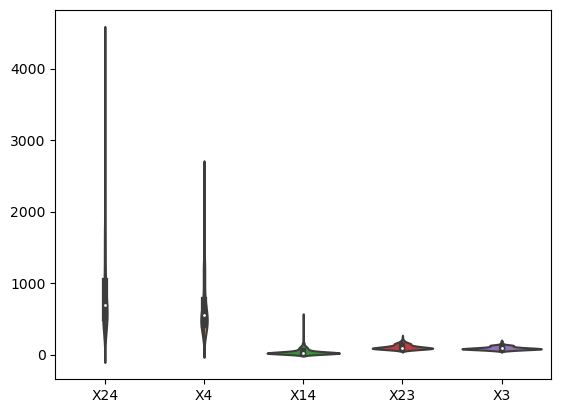

In [13]:
#Making Violin Plots
std_dev = train_df.std(numeric_only=True).sort_values(ascending=False)[:5]
sns.violinplot(data=train_df[std_dev.index])

In [14]:
#Removing outliers using IQR
Q1 = train_df.quantile(0.25,numeric_only=True)
Q3 = train_df.quantile(0.75,numeric_only=True)
IQR = Q3 - Q1 # difference between the third and first quartiles
train_df = train_df[~((train_df < (Q1 - 1.5 * IQR)) | (train_df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [15]:
### Write your code here
class LogisticRegression():
    def __init__(self, X, y):
        self.X = X
        self.y = y.values.reshape(-1,1)
        
    def fit(self, max_iter= 100, tolerance=1e-6, lr=0.001):         
        # generate a random Beta matrix for 1st iteration
        B = np.zeros((self.X.shape[1],1)) 
        
        ## define optimizer
        optim = Optimization(self.X, self.y, Loss.cross_entropy_loss)
        B, loss, test_loss = optim.newton_optimization(B, max_iter, tolerance, lr)
        self.B = B
        return B,loss,test_loss
    
    def predict(self,X):
        scores = np.matmul(X,self.B)
        return 1./(1+np.exp(-scores))

In [16]:
#Splititng data into x and y
X = log_reg_data.iloc[:,1:]
y = log_reg_data.iloc[:,0]
#let's split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalizing the data
X_train_normalized = Functions().normalize_features(X_train)
X_test_normalized = Functions().normalize_features(X_test)
# fitting the model
log_reg_model = LogisticRegression(X_train_normalized,y_train)
log_reg_model_params,train_loss,test_loss = log_reg_model.fit()

In [17]:
log_reg_model_preds = log_reg_model.predict(X_test_normalized)
accuracy,P,R,F,c = Functions().calculate_metrics(y_test,(log_reg_model_preds>0.5).reshape(-1))

In [18]:
print('The accuracy of the model is',accuracy)
print('The Precision of the model is',P)
print('The Recall of the model is',R)
print('The F-Score of the model is',F)
print('The Confusion Matrix formed by the model is \n',c)

The accuracy of the model is 0.9210526315789473
The Precision of the model is 0.9473684210526315
The Recall of the model is 0.8372093023255814
The F-Score of the model is 0.8888888888888888
The Confusion Matrix formed by the model is 
 [[69.  2.]
 [ 7. 36.]]


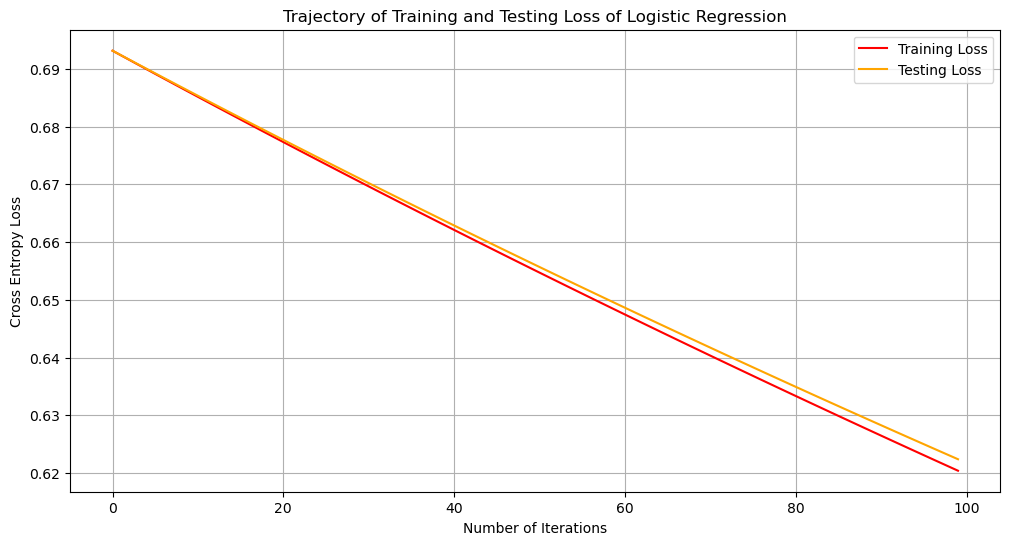

In [19]:
#Trajectory of the Loss
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

**Point to Ponder**

Read about precision, recall and F-score. Suppose model A and model B both have same accuracy, but model B has a higher F-score, which model would be suited? 

**Answer:** The model B would be more suited. Even though both models have the same accuracy, model B has a higher F-score. The F-score is a measure of a test's accuracy and considers both the precision and the recall of the test. Precision is the number of true positive results divided by the number of all positive results, while recall is the number of true positive results divided by the number of positive results that should have been returned.

Therefore, a higher F-score suggests that model B has a better balance of precision and recall, making it more reliable in a wider range of situations. This is especially important in cases where false positives and false negatives have different costs.

### Part 4

**Discriminant Analysis**

In this part of the assignment you will implement linear and quadratic discriminant analysis classifiers on the iris dataset *from scratch*. Again, this should follow an object oriented method of implementation where you need 2 classes $\textbf{LDA()}$ and $\textbf{QDA()}$ with the associated $\textbf{fit()}$ and $\textbf{predict()}$ methods.


In [20]:
from sklearn import datasets
import pandas as pd
import numpy as np
iris = datasets.load_iris()
df_iris = pd.DataFrame(np.hstack([iris.data,iris.target[...,np.newaxis]]),columns=['X1', 'X2', 'X3', 'X4', "Y"])

#let's separate features
X = df_iris.iloc[:,:-1] #separate independent variables 
y = df_iris.iloc[:,-1].values #separate target variables 

In [21]:
### Write your code here
#For QDA
class QDA:
    def __init__(self,X,y):
        #initializing the class
        self.X = X
        self.y = y
        self.classes = np.unique(self.y)
        self.num_classes = len(np.unique(self.y))
    
    #function to estimate the best parameters and make the model
    def fit(self):
        #first define the mean
        mean_k = [] #list that will store the mean of each class
        sigma_k = [] #list that will store the covariance matrix of each class
        pi_k = [] #list that will store the pi values for all the class K
        for k in self.classes: #iterating over each class and storing its estimates
            ind = self.y == k #indices where y belongs to class K
            xk = self.X[ind] #X's for class k
            mean_k.append(xk.mean(axis=0)) #mean with respect to class K
            sigma_k.append(np.cov(xk,bias=True,rowvar=False)) #covariance matrix with respect to class K
            pi_k.append(len(xk)/len(self.X)) #pi_k for the class K
        self.mean_k,self.sigma_k,self.pi_k = mean_k,sigma_k,pi_k
        return self.mean_k,self.sigma_k,self.pi_k
    
    #output the class of the data according to discriminant analysis
    def predict(self,X):
        mean_k,sigma_k,pi_k = self.mean_k,self.sigma_k,self.pi_k
        delta_k = [] #this will record the predicted class for each variable
        for x in X: #iterating over each observation 
            delta_x = [] #empty list to store delta_k for each observtion
            for k in range(self.num_classes): #iterating over each class
                diff = x - mean_k[k] 
                mahalanobis_distance = diff.T @ np.linalg.inv(sigma_k[k]) @ diff
                d = -1/2*np.log(np.linalg.det(sigma_k[k]))-1/2*mahalanobis_distance+np.log(pi_k[k])
                delta_x.append(d) #append the kth delta_k value of observation
            delta_k.append(np.argmax(delta_x)) #append all values of delta_k of each variable in a list
        return np.array(delta_k)
    
#For LDA
class LDA:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(self.y))
    
    #function to estimate the best parameters and make the model
    def fit(self):
        # since LDA is almost similar to QDA, we will estimate the parameters by using the QDA class
        qda = QDA(self.X,self.y)
        mean_k,sigma_k,pi_k = qda.fit()
        # now we will take the weighted sum of the cov matrix
        sigma = np.zeros(shape=(self.num_features,self.num_features))
        for k in range(self.num_classes):
            sigma = np.add(sigma,pi_k[k] * sigma_k[k])
        self.mean_k,self.sigma,self.pi_k = mean_k,sigma,pi_k
        return self.mean_k,self.sigma,self.pi_k
            
    
    #output the class of the data according to discriminant analysis
    def predict(self,X):
        mean_k,sigma,pi_k = self.mean_k,self.sigma,self.pi_k
        delta_k = [] #this will record the predicted class for each variable
        for x in X: #iterating over each observation 
            delta_x = [] #empty list to store delta_k for each observtion
            for k in range(self.num_classes): #iterating over each class
                diff = x - mean_k[k]
                mahalanobis_distance = diff.T @ np.linalg.inv(sigma) @ diff
                d = -1/2*np.log(np.linalg.det(sigma))-1/2*mahalanobis_distance+np.log(pi_k[k])
                delta_x.append(d) #append the kth delta_k value of observation
            delta_k.append(np.argmax(delta_x)) #append all values of delta_k of each variable in a list
        return np.array(delta_k)

In [22]:
## let's split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#For QDA
qda_model = QDA(X_train,y_train)
#train it
qda_model.fit();
#obtaining predictions
qda_pred = qda_model.predict(X_test.values)

#For LDA
#defining the model
lda_model = LDA(X_train,y_train)
#estimating the parameters
lda_model.fit()
#predicting on the test set
lda_pred = lda_model.predict(X_test.values)

In [24]:
#let's calculate the test accuracies of both LDA and QDA
def calculate_accuracy(true, pred):
    accuracy = np.sum(true == pred)/len(pred)
    #accuracy = 1-np.sum(np.abs(np.subtract(pred,true)))/len(pred)
    return np.round(accuracy,3)

In [25]:
print('The Test Accuracy of the QDA model is',calculate_accuracy(y_test,qda_pred))
print('The Test Accuracy of the LDA model is',calculate_accuracy(y_test,lda_pred))

The Test Accuracy of the QDA model is 0.967
The Test Accuracy of the LDA model is 1.0


**Evaluation**

Compare your implementation with those of sklearn Library, both in terms of accuracy and timing. Visualize all comparisons in a meaningful manner.

In [26]:
### Write your code here
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
sklearn_lda = LinearDiscriminantAnalysis()
sklearn_lda.fit(X_train,y_train)
sklearn_qda = QuadraticDiscriminantAnalysis()
sklearn_qda.fit(X_train,y_train)

print('The Test Accuracy of the Sklearn QDA model is',calculate_accuracy(y_test,sklearn_qda.predict(X_test)))
print('The Test Accuracy of the Sklearn LDA model is',calculate_accuracy(y_test,sklearn_lda.predict(X_test)))

The Test Accuracy of the Sklearn QDA model is 0.967
The Test Accuracy of the Sklearn LDA model is 1.0


Our implementation matches the Sklearn's implementation